In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
from tensorflow.keras.preprocessing.image import load_img 

In [12]:
path = 'clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname, target_size=(150,150))

In [16]:
img = load_img(fullname, target_size=(299,299))

In [17]:
x = np.array(img)

## **Pretrained CNN**

In [27]:
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

In [15]:
model = Xception(weights='imagenet', input_shape=(299,299,3))

91889664/91884032 [==============================] - 7s 0us/step


In [18]:
X = np.array([x])

In [24]:
X = preprocess_input(X)

In [26]:
pred = model.predict(X)
pred.shape

(1, 1000)

In [28]:
decode_predictions(pred)

40960/35363 [==================================] - 0s 1us/step


[[('n03595614', 'jersey', 0.67924494),
  ('n02916936', 'bulletproof_vest', 0.03960036),
  ('n04370456', 'sweatshirt', 0.035299625),
  ('n03710637', 'maillot', 0.010884151),
  ('n04525038', 'velvet', 0.0018057632)]]

## **Convolutional Neural Networks**

## **Transfer Learning**

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', 
                              target_size=(150,150), 
                              batch_size=32)

Found 3068 images belonging to 10 classes.


In [34]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [39]:
X, y = next(train_ds)

In [40]:
y[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [41]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', 
                              target_size=(150,150), 
                              batch_size=32,
                                    shuffle=False)

Found 341 images belonging to 10 classes.


In [42]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

base_model.trainable=False

83689472/83683744 [==============================] - 6s 0us/step


In [57]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [58]:
preds = model.predict(X)

In [59]:
preds.shape

(32, 10)

In [60]:
learning_rate = .01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [61]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [62]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 89s 903ms/step - loss: 1.6948 - accuracy: 0.5875 - val_loss: 0.8253 - val_accuracy: 0.7566
Epoch 2/10
96/96 [==============================] - 79s 827ms/step - loss: 0.5912 - accuracy: 0.8159 - val_loss: 0.8215 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 78s 809ms/step - loss: 0.3511 - accuracy: 0.8809 - val_loss: 0.7594 - val_accuracy: 0.8211
Epoch 4/10
96/96 [==============================] - 78s 816ms/step - loss: 0.2270 - accuracy: 0.9183 - val_loss: 0.8722 - val_accuracy: 0.8182
Epoch 5/10
96/96 [==============================] - 79s 822ms/step - loss: 0.1589 - accuracy: 0.9352 - val_loss: 0.8480 - val_accuracy: 0.7977
Epoch 6/10
96/96 [==============================] - 78s 811ms/step - loss: 0.0859 - accuracy: 0.9704 - val_loss: 0.8130 - val_accuracy: 0.8270
Epoch 7/10
96/96 [==============================] - 78s 809ms/step - loss: 0.0542 - accuracy: 0.9837 - val_loss: 0.8192 - val_accuracy: 0.8211

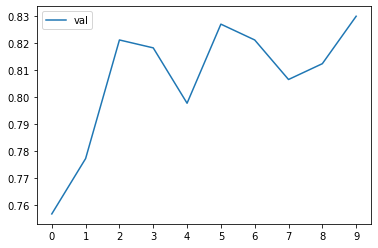

In [65]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## **Adjusting the learning rate**

In [67]:
def make_model(learning_rate=.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )

    base_model.trainable=False
##################################################    
    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    outputs = keras.layers.Dense(10)(vectors)

    model = keras.Model(inputs, outputs)
##################################################    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer, 
         loss=loss, 
         metrics=['accuracy'])
    
    return model

In [68]:
scores = {}

for lr in [0.0001, .001, .01, .1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 80s 809ms/step - loss: 2.1254 - accuracy: 0.2799 - val_loss: 1.6118 - val_accuracy: 0.5279
Epoch 2/10
96/96 [==============================] - 77s 801ms/step - loss: 1.4690 - accuracy: 0.5542 - val_loss: 1.2561 - val_accuracy: 0.6393
Epoch 3/10
96/96 [==============================] - 77s 802ms/step - loss: 1.1663 - accuracy: 0.6304 - val_loss: 1.0756 - val_accuracy: 0.6950
Epoch 4/10
96/96 [==============================] - 77s 806ms/step - loss: 0.9988 - accuracy: 0.6880 - val_loss: 0.9622 - val_accuracy: 0.7273
Epoch 5/10
96/96 [==============================] - 78s 810ms/step - loss: 0.9137 - accuracy: 0.7184 - val_loss: 0.8891 - val_accuracy: 0.7449
Epoch 6/10
96/96 [==============================] - 78s 809ms/step - loss: 0.8537 - accuracy: 0.7194 - val_loss: 0.8372 - val_accuracy: 0.7507
Epoch 7/10
96/96 [==============================] - 77s 802ms/step - loss: 0.7919 - accuracy: 0.7474 - val_loss: 0.8010 - val_accuracy:

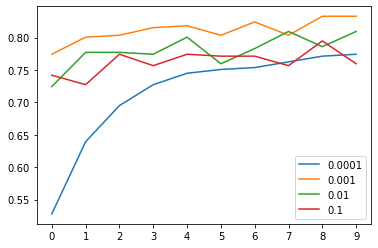

In [69]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

In [70]:
learning_rate = .001

## **Checkpointing**

In [71]:
model

In [74]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
    )


lr = .001
model = make_model(learning_rate=lr)
history = model.fit(
        train_ds, 
        epochs=10, 
        validation_data=val_ds,
        callbacks=checkpoint
        )
scores[lr] = history.history

Epoch 1/10
96/96 [==============================] - 92s 926ms/step - loss: 1.4261 - accuracy: 0.5184 - val_loss: 0.6961 - val_accuracy: 0.7830
Epoch 2/10
96/96 [==============================] - 83s 861ms/step - loss: 0.6163 - accuracy: 0.7860 - val_loss: 0.5906 - val_accuracy: 0.8152
Epoch 3/10
96/96 [==============================] - 82s 849ms/step - loss: 0.5121 - accuracy: 0.8342 - val_loss: 0.5692 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 80s 835ms/step - loss: 0.4113 - accuracy: 0.8754 - val_loss: 0.5607 - val_accuracy: 0.8035
Epoch 5/10
96/96 [==============================] - 79s 825ms/step - loss: 0.3570 - accuracy: 0.8878 - val_loss: 0.5399 - val_accuracy: 0.8270
Epoch 6/10
96/96 [==============================] - 79s 824ms/step - loss: 0.3172 - accuracy: 0.9126 - val_loss: 0.5602 - val_accuracy: 0.8182
Epoch 7/10
96/96 [==============================] - 79s 819ms/step - loss: 0.2799 - accuracy: 0.9303 - val_loss: 0.5418 - val_accuracy: 0.8182

## **Adding more layers**

In [80]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [81]:
scores = {}

lr = .001
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=lr, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 82s 824ms/step - loss: 1.9667 - accuracy: 0.2184 - val_loss: 1.5476 - val_accuracy: 0.4897
Epoch 2/10
96/96 [==============================] - 78s 808ms/step - loss: 1.4124 - accuracy: 0.5062 - val_loss: 1.2682 - val_accuracy: 0.5689
Epoch 3/10
96/96 [==============================] - 78s 813ms/step - loss: 1.1382 - accuracy: 0.5832 - val_loss: 0.9700 - val_accuracy: 0.6686
Epoch 4/10
96/96 [==============================] - 82s 852ms/step - loss: 0.7801 - accuracy: 0.7520 - val_loss: 0.7676 - val_accuracy: 0.7537
Epoch 5/10
96/96 [==============================] - 79s 821ms/step - loss: 0.5682 - accuracy: 0.8230 - val_loss: 0.6878 - val_accuracy: 0.7830
Epoch 6/10
96/96 [==============================] - 77s 807ms/step - loss: 0.4827 - accuracy: 0.8518 - val_loss: 0.6606 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 78s 808ms/step - loss: 0.4487 - accuracy: 0.8692 - val_loss: 0.6578 - val_accuracy: 0.7

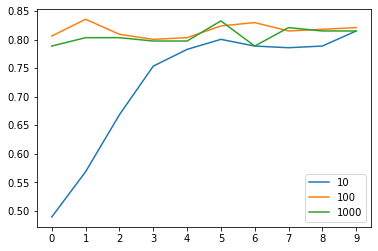

In [82]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=size)

plt.xticks(np.arange(10))
plt.legend()

In [83]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.2):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

## **Data augmentation**

In [84]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False
)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', 
                              target_size=(150,150), 
                              batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', 
                              target_size=(150,150), 
                              batch_size=32,
                                    shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [85]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [86]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 [==============================] - 92s 929ms/step - loss: 1.5195 - accuracy: 0.5091 - val_loss: 0.7570 - val_accuracy: 0.7566
Epoch 2/50
96/96 [==============================] - 83s 860ms/step - loss: 0.8827 - accuracy: 0.7066 - val_loss: 0.7251 - val_accuracy: 0.7507
Epoch 3/50
96/96 [==============================] - 79s 821ms/step - loss: 0.6794 - accuracy: 0.7820 - val_loss: 0.6500 - val_accuracy: 0.7977
Epoch 4/50
96/96 [==============================] - 78s 811ms/step - loss: 0.6049 - accuracy: 0.8021 - val_loss: 0.6261 - val_accuracy: 0.8094
Epoch 5/50
96/96 [==============================] - 78s 813ms/step - loss: 0.5034 - accuracy: 0.8324 - val_loss: 0.6016 - val_accuracy: 0.8035
Epoch 6/50
96/96 [==============================] - 78s 812ms/step - loss: 0.4534 - accuracy: 0.8522 - val_loss: 0.6091 - val_accuracy: 0.7977
Epoch 7/50
96/96 [==============================] - 77s 805ms/step - loss: 0.4088 - accuracy: 0.8609 - val_loss: 0.6380 - val_accuracy: 0.8035

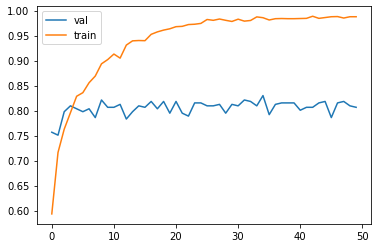

In [87]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## **Using the Model**

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

In [ ]:
model = keras.models.load_model('xception_v4_1_13_0.903.h5')
model.evaluate(test_ds)

In [ ]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [ ]:
img = load_img(path, target_size=(299, 299))

In [ ]:
import numpy as np

In [ ]:
x = np.array(img)
X = np.array([x])
X.shape

In [ ]:
(1, 299, 299, 3)

In [ ]:
X = preprocess_input(X)

In [ ]:
pred = model.predict(X)

In [ ]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [ ]:
dict(zip(classes, pred[0]))